In [1]:
import torch
import torch.nn as nn
import torchtext
import pandas as pd
import unicodedata
import re
import random
import torch.utils.data as tud
import numpy as np
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

## 1.加载数据 建立input pipeline

In [2]:
data_df = pd.read_csv('data/eng-fra.txt',  # 数据格式：英语\t法语，注意我们的任务源语言是法语，目标语言是英语
                      encoding='UTF-8', sep='\t', header=None,
                      names=['eng', 'fra'], index_col=False)

print(data_df.shape)
print(data_df.values.shape)
print(data_df.values[0])
print(data_df.values[0].shape)
data_df.head()

(135842, 2)
(135842, 2)
['Go.' 'Va !']
(2,)


,eng,fra
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [3]:
# 数据预处理

# 将unicode字符串转化为ASCII码：
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# 规范化字符串
def normalizeString(s):
    # print(s) # list  ['Go.']
    # s = s[0]
    s = s.lower().strip()
    s = unicodeToAscii(s)
    s = re.sub(r"([.!?])", r" \1", s)  # \1表示group(1)即第一个匹配到的 即匹配到'.'或者'!'或者'?'后，一律替换成'空格.'或者'空格!'或者'空格？'
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # 非字母以及非.!?的其他任何字符 一律被替换成空格
    s = re.sub(r'[\s]+', " ", s)  # 将出现的多个空格，都使用一个空格代替。例如：w='abc  1   23  1' 处理后：w='abc 1 23 1'
    return s


print(normalizeString('Va !'))
print(normalizeString('Go.'))

va !
go .


In [4]:
MAX_LENGTH = 10

eng_prefixes = (  # 之前normalizeString()已经对撇号等进行了过滤，以及清洗，小写化等
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# print(eng_prefixes)
pairs = [[normalizeString(s) for s in line] for line in data_df.values]

print('pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])

pairs num= 135842
['go .', 'va !']
['run !', 'cours !']


In [5]:
# 文件是英译法，我们实现的是法译英，所以进行了reverse，所以pair[1]是英语
# 为了快速训练，仅保留“我是”“你是”“他是”等简单句子，并且删除原始文本长度大于10个标记的样本
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
           p[0].startswith(eng_prefixes)  # startswith first arg must be str or a tuple of str


def filterPairs(pairs):
    # 过滤，并交换句子顺序，得到法英句子对（之前是英法句子对）
    return [pair for pair in pairs if filterPair(pair)]


pairs = filterPairs(pairs)

print('after trimming, pairs num=', len(pairs))
print(pairs[0])
print(pairs[1])
print(random.choice(pairs))


after trimming, pairs num= 10599
['i m .', 'j ai ans .']
['i m ok .', 'je vais bien .']
['she s a very nice girl .', 'c est une tres gentille fille .']


In [6]:
# 划分数据集：训练集和验证集
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=1234)

print(len(train_pairs))
print(len(val_pairs))

8479
2120


In [7]:
tokenizer = lambda x: x.split() # 分词器
VOCAB_SIZE = 2500

class vocab:

    def __init__(self, vocab_size, seqs, tokenizer):
        """
        - vocab_size: 字典大小
        - seqs: 待构建字典的句子
        - tokenizer: 分割token的方法
        """
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.itos, self.stoi = self.build_vocab(seqs)
    
    def build_vocab(self, seqs):
        tokens = []
        for seq in tqdm(seqs):
            tokens += self.tokenizer(seq)
        
        token_dict = dict(Counter(tokens).most_common(self.vocab_size-4))
        itos = ['<unk>', '<pad>', '<end>', '<start>'] + list(token_dict.keys())
        stoi = {}
        for i, t in enumerate(itos):
            stoi[t] = i
        
        return itos, stoi


SRC_VOCAB = vocab(VOCAB_SIZE, [pair[0] for pair in pairs], tokenizer)
TARG_VOCAB = vocab(VOCAB_SIZE, [pair[1] for pair in pairs], tokenizer)

100%|██████████| 10599/10599 [00:00<00:00, 1766417.46it/s]


In [8]:
class eng2fra_dataset(tud.Dataset):

    def __init__(self, pairs, max_len, tokenizer, SRC_VOCAB, TARG_VOCAB) -> None:
        super().__init__()
        self.pairs = pairs
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.SRC_VOCAB = SRC_VOCAB
        self.TARG_VOCAB = TARG_VOCAB
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        src, targ = pairs[index]
        src = [self.SRC_VOCAB.stoi.get(t, 0) for t in self.tokenizer(src)][:self.max_len]
        src = src + [1 for _ in range(self.max_len - len(src))]

        targ = [self.TARG_VOCAB.stoi.get(t, 0) for t in self.tokenizer(targ)][:self.max_len]
        targ = targ + [1 for _ in range(self.max_len - len(targ))]

        return torch.tensor(src, dtype=torch.long), torch.tensor(targ, dtype=torch.long)

trainset = eng2fra_dataset(train_pairs, 15, tokenizer, SRC_VOCAB, TARG_VOCAB)
valset = eng2fra_dataset(val_pairs, 15, tokenizer, SRC_VOCAB, TARG_VOCAB)

In [9]:
trainloader = tud.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = tud.DataLoader(valset, batch_size=128, shuffle=False)

print(next(iter(trainloader))[0])

tensor([[  5,   8,  71,  ...,   1,   1,   1],
        [ 20,  11,  10,  ...,   1,   1,   1],
        [ 20,  11, 277,  ...,   1,   1,   1],
        ...,
        [  7,   6, 617,  ...,   1,   1,   1],
        [ 14,  18,  59,  ...,   1,   1,   1],
        [ 14,   6,  97,  ...,   1,   1,   1]])


## 2.Positional Encoding
每个位置 PE 的计算方法:
$$PE(pos, 2i)=sin(\frac{pos}{10000^{2i/d_{model}}})$$
$$PE(pos, 2i+1)=cos(\frac{pos}{10000^{2i/d_{model}}})$$
特点:
- 后边位置的编码是前边位置的线性组合, 保证了即便两个位置不是相邻的, 也可能有一定的关系
- 每个位置的编码又是独特的
- 每两个位置的encoding做点积, 位置越远, 点积的结果越小

In [10]:
# 计算角度：pos * 1/(10000^(2i/d))
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, 2 * (i // 2) / np.float32(d_model))  # => [1, 512]
    return pos * angle_rates  # [50,1]*[1,512]=>[50, 512]

def positional_encoding(position, d_model):  # d_model是位置编码的长度，相当于position encoding的embedding_dim？
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # [50, 1]
                            np.arange(d_model)[np.newaxis, :],  # [1, d_model=512]
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 2i
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 2i+1

    pos_encoding = angle_rads[np.newaxis, ...]  # [50,512]=>[1,50,512]
    return torch.tensor(pos_encoding, dtype=torch.float32)

pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape) # [1,50,512]

torch.Size([1, 50, 512])



$$divterm=pos*exp(-ln(10000) \cdot 2i / d_{model})$$


In [11]:
"""
来自 Pytorch 官方文档中的 PositionalEncoding, 把 batch_size 调到了前边
"""
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1) # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # [d_model // 2]
        pe = torch.zeros(1, max_len, d_model) # [max_len, 1, d_model]
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        "x: Tensor, shape [batch_size, seq_len, embedding_dim]"
        x = x + self.pe[:, :x.size(1), :]
        return x

In [12]:
pe = PositionalEncoding(d_model=512, max_len=50)

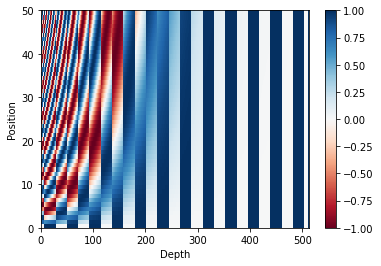

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

def draw_pos_encoding(pos_encoding):
    plt.figure()
    plt.pcolormesh(pos_encoding[0], cmap='RdBu') # 绘制分类图
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar() # 条形bar颜色图例
    plt.show()

draw_pos_encoding(pos_encoding)

## 3.掩码mask
两种mask:
- padding mask: 句子中为pad的位置mask为1
- look-ahead mask: mask future token, 将当前token后边的词mask掉

In [14]:
pad = 1
def create_padding_mask(seq):  # seq [b, seq_len]
    # seq = torch.eq(seq, torch.tensor(0)).float() # pad=0的情况
    seq = torch.eq(seq, torch.tensor(pad)).float()  # pad!=0
    return seq[:, np.newaxis, np.newaxis, :]  # =>[b, 1, 1, seq_len]

seq = torch.tensor([[32, 12, 43, 2, 1, 1, 1], [28, 12, 4, 1, 1, 1, 1]])
create_padding_mask(seq)

tensor([[[[0., 0., 0., 0., 1., 1., 1.]]],


        [[[0., 0., 0., 1., 1., 1., 1.]]]])

In [15]:
def create_look_ahead_mask(size):  # seq_len
    mask = torch.triu(torch.ones((size, size)), diagonal=1)
    return mask  # [seq_len, seq_len]

x = torch.randn(2, 3)
create_look_ahead_mask(x.size(1))

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])

In [16]:
def generate_square_subsequent_mask(sz: int):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

generate_square_subsequent_mask(x.size(1))

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])

## 4.scaled dot product attention
$$Attention(Q,K,V)=softmax_{(k)}(\frac{QK^T}{\sqrt{d_k}})V$$

注意：实现时对mask的处理
mask=1的位置是pad或者future token，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0

In [18]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    自注意力机制
    - q: query, shape: [..., seq_len_q, depth]
    - k: key, shape: [..., seq_len_k, depth]
    - v: value, shape: [..., seq_len_v, depth_v], seq_len_k == seq_len_v
    有seq_len_q个query, seq_len_k个key, 计算其注意力值及其输出
    """
    # q, k做矩阵乘法, 得到各个query查询各个key得到的value
    matmul_qk = torch.matmul(q, k.transpose(-1, -2)) # [..., seq_len_q, seq_len_k]
    
    # 将得到的value除以sqrt(d_k), 使其不至于太大, 不然输入到softmax后容易导致梯度消失
    dk = torch.tensor(k.shape[-1], dtype=torch.float32) # d_k
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)

    # 需要 mask 的位置加上一个很大的负值, 使其输入到softmax之后对应概率为0
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # 计算Attention权重矩阵
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1) # [..., seq_len_q, seq_len_k]
    
    # 各个value按Attention矩阵加权, 得到各个query对应的最终输出
    output = torch.matmul(attention_weights, v) # [..., seq_len_q, depth_v]
    return output, attention_weights 


In [19]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True) # 设置不以科学计数法的形式显示数据

temp_k = torch.tensor([[10,0,0],
                       [0,10,0],
                       [0,0,10],
                       [0,0,10]], dtype=torch.float32) # [4,3]

temp_v = torch.tensor([[1,0],
                       [10,0],
                       [100,5],
                       [1000,6]], dtype=torch.float32) #[4,2]

In [20]:
# 单个query
temp_q = torch.tensor([[0,10,0]], dtype=torch.float32) # [1,3]
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [ ]:
# 传入所有的query
temp_q = torch.tensor([[0, 0, 10], 
                       [0, 10, 0], 
                       [10, 10, 0]], dtype=torch.float32)  # (3, 3)

print_out(temp_q, temp_k, temp_v)